In [40]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import random
from scipy.spatial.distance import pdist, squareform

# Objective Function
## Pareto Frontier of Sharpe Ratio and ESG Score

The Sharpe Ratio is defined as:

$$
\text{Sharpe Ratio} = \frac{\sum_{i=1}^n w_i \mu_i - R_f}{\sqrt{w^T \Sigma w}}
$$

Where:
- $μ_i$ = Portfolio return  
- $R_f$ = Risk-free rate  
- $σ_p$ = Portfolio volatility (standard deviation)
- $Σw$	= Covariance matrix

In [43]:
# gather ticker info from Alpha Vantage API
API_KEY = "OD76BXNCWU9GO4WP"
symbols = ["MSFT", "AAPL", "NVDA", "UNH", "JNJ"]
test = ["FNCMX", "FSELX", "FSPGX", "FTIHX", "FXAIX", "FZROX"]

weights = []

esg_scores = [85,80,75,70,65]

def fetch_daily_prices(ticker):
    url = "https://www.alphavantage.co/query"
    params = {
        "function": "TIME_SERIES_DAILY",
        "symbol": ticker,
        "apikey": API_KEY,
        "outputsize": "full"
    }

    response = requests.get(url, params=params)
    data = response.json()

    # Check for valid time series key
    time_series_key = next((key for key in data if "Time Series" in key), None)
    if not time_series_key:
        print(f"[Error] No time series for {ticker}. Response: {data}")
        return pd.Series(dtype=float)  # Empty series

    df = pd.DataFrame(data[time_series_key]).T
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    df["close"] = df["4. close"].astype(float)

    return df["close"].iloc[-1260:]  # Last 5 years of trading days

def fetch_all_prices(symbols, output_file="daily_close_prices.csv"):
    all_prices = {}

    for i, symbol in enumerate(symbols):
        print(f"[{i+1}/{len(symbols)}] Fetching {symbol}...")
        all_prices[symbol] = fetch_daily_prices(symbol)

    df = pd.DataFrame(all_prices)
    df.to_csv(output_file)
    print(f"\n Saved data to {output_file}")
    return df

In [30]:

df_prices = fetch_all_prices(symbols)

[1/5] Fetching MSFT...
[2/5] Fetching AAPL...
[3/5] Fetching NVDA...
[4/5] Fetching UNH...
[5/5] Fetching JNJ...

 Saved data to daily_close_prices.csv


In [45]:
cached_5prices = df_prices
def evaluate_objectives(weights, prices_df, esg_vector, risk_free_rate=0.02):
    # Ensure weights are non-negative and sum to 1
    weights = np.array(weights)
    weights = np.clip(weights, 0, None)
    if np.sum(weights) == 0:
        weights = np.ones_like(weights) / len(weights)
    weights /= np.sum(weights)

    # Calculate daily returns
    daily_returns = prices_df.pct_change().dropna()
    mean_daily_returns = daily_returns.mean()
    mean_annual_returns = (1 + mean_daily_returns) ** 252 - 1
    cov_matrix_annual = daily_returns.cov() * 252

    # Portfolio return
    portfolio_return = np.dot(weights, mean_annual_returns)

    # Portfolio volatility (handling zero variance case)
    portfolio_variance = np.dot(weights.T, np.dot(cov_matrix_annual, weights))
    if portfolio_variance <= 0:
        print(f"[Warning] Zero or negative portfolio variance for weights: {weights}")
        return np.nan, np.dot(weights, esg_vector)

    portfolio_volatility = np.sqrt(portfolio_variance)

    # Sharpe ratio
    sharpe_ratio = (portfolio_return - risk_free_rate) / (portfolio_volatility + 1e-8)

    # ESG score
    esg_score = np.dot(weights, esg_vector)

    return sharpe_ratio, esg_score

In [262]:
def dominates(a, b, epsilon=1e-6):
    """
    Efficient dominance check with a small tolerance.
    """
    strictly_better = False
    for x, y in zip(a, b):
        if x < y - epsilon:
            return False  # Early exit if a is not better in any dimension
        elif x > y + epsilon:
            strictly_better = True

    return strictly_better
    
def update_pareto_archive(archive, candidate_objectives, candidate_weights):
    """
    Efficient archive update without full resets, preserving all non-dominated solutions.
    """
    candidate_tuple = (*candidate_objectives, tuple(candidate_weights))

    # Check if candidate is already in the archive
    if candidate_tuple in [(s, e, tuple(w)) for s, e, w in archive]:
        return archive

    # Filter only non-dominated solutions
    filtered_archive = []
    for (s, e, w) in archive:
        # If the candidate is dominated, it is rejected
        if dominates((s, e), candidate_objectives):
            return archive  # Early exit, candidate is dominated
        
        # Keep existing non-dominated solutions
        if not dominates(candidate_objectives, (s, e)):
            filtered_archive.append((s, e, w))

    # Add the new candidate
    filtered_archive.append((*candidate_objectives, candidate_weights))

    return filtered_archive
    
def normalize_weights(w, min_weight=0.01, max_weight=0.3):
    # Leniently enforce minimum and maximum weight
    w = np.clip(w, min_weight, max_weight)
    return w / np.sum(w)
    
def initialize_population(num_bees, prices_df, esg_vector):
    num_assets = prices_df.shape[1]  # number of stocks

    foods = []
    objectives = []
    trials = np.zeros(num_bees)
    pareto_archive = []

    for _ in range(num_bees):
        # Step 1: Generate random weight vector
        weights = normalize_weights(0.1 + 0.9 * np.random.rand(num_assets))

        # Step 2: Evaluate objectives (Sharpe, ESG)
        sharpe, esg = evaluate_objectives(weights, prices_df, esg_vector)

        # Step 3: Add to food list and objectives
        foods.append(weights)
        objectives.append((sharpe, esg))

        # Step 4: Update Pareto archive
        pareto_archive = update_pareto_archive(pareto_archive, (sharpe, esg), weights)
    return foods, objectives, trials, pareto_archive
    
def employed_bee_phase(foods, objectives, trials, prices_df, esg_vector, pareto_archive):
    num_bees = len(foods)
    num_assets = len(foods[0])

    for i in range(num_bees):
        # Step 1: Pick a random parameter (asset weight) to mutate
        param2change = random.randint(0, num_assets - 1)

        # Step 2: Pick a different random neighbor bee
        neighbour = random.randint(0, num_bees - 1)
        while neighbour == i:
            neighbour = random.randint(0, num_bees - 1)

        # Step 3: Generate new solution by ABC mutation formula
        phi = (random.random() - 0.5) * 2
        candidate = np.copy(foods[i])
        candidate[param2change] += phi * (foods[i][param2change] - foods[neighbour][param2change])

        # Step 4: Clip and normalize the candidate
        candidate = normalize_weights(candidate)
        # Step 5: Evaluate objectives
        new_objectives = evaluate_objectives(candidate, prices_df, esg_vector)

        # Step 6: Compare and decide
        if dominates(new_objectives, objectives[i]):
            # Accept new solution
            foods[i] = candidate
            objectives[i] = new_objectives
            trials[i] = 0
        else:
            trials[i] += 1  # No improvement

        # Step 7: Update Pareto archive regardless
        pareto_archive = update_pareto_archive(pareto_archive, new_objectives, candidate)

    return foods, objectives, trials, pareto_archive

def compute_probabilities(objectives):
    sharpes = [s for s, e in objectives]
    esgs = [e for s, e in objectives]

    # Normalize to [0, 1]
    sharpes_norm = [(s - min(sharpes)) / (max(sharpes) - min(sharpes) + 1e-8) for s in sharpes]
    esgs_norm = [(e - min(esgs)) / (max(esgs) - min(esgs) + 1e-8) for e in esgs]

    # Combine them
    scores = [(0.5 * s + 0.5 * e) for s, e in zip(sharpes_norm, esgs_norm)]
    total = sum(scores)
    probabilities = [s / total for s in scores]
    return probabilities

def onlooker_bee_phase(foods, objectives, trials, prices_df, esg_vector, pareto_archive):
    num_bees = len(foods)
    num_assets = len(foods[0])
    probabilities = compute_probabilities(objectives)

    i = 0
    t = 0
    while t < num_bees:
        if random.random() < probabilities[i]:
            t += 1

            # Mutation
            param2change = random.randint(0, num_assets - 1)
            neighbour = random.randint(0, num_bees - 1)
            while neighbour == i:
                neighbour = random.randint(0, num_bees - 1)

            phi = (random.random() - 0.5) * 2
            candidate = np.copy(foods[i])
            candidate[param2change] += phi * (foods[i][param2change] - foods[neighbour][param2change])

            candidate = normalize_weights(candidate)

            new_objectives = evaluate_objectives(candidate, prices_df, esg_vector)

            if dominates(new_objectives, objectives[i]):
                foods[i] = candidate
                objectives[i] = new_objectives
                trials[i] = 0
            else:
                trials[i] += 1

            pareto_archive = update_pareto_archive(pareto_archive, new_objectives, candidate)

        i = (i + 1) % num_bees

    return foods, objectives, trials, pareto_archive

def scout_bee_phase(foods, objectives, trials, prices_df, esg_vector, pareto_archive, limit=10):
    num_bees = len(foods)
    num_assets = len(foods[0])

    for i in range(num_bees):
        if trials[i] >= limit:
            # Replace this food source with a new random one
            new_weights = 0.1 + 0.2 * np.random.rand(num_assets)
            new_weights = new_weights / np.sum(new_weights)

            new_objectives = evaluate_objectives(new_weights, prices_df, esg_vector)

            foods[i] = new_weights
            objectives[i] = new_objectives
            trials[i] = 0  # reset trial count

            pareto_archive = update_pareto_archive(pareto_archive, new_objectives, new_weights)

    return foods, objectives, trials, pareto_archive
def plot_pareto_archive(archive, cycle):
    sharpes = [s for s, e, _ in archive]
    esgs = [e for s, e, _ in archive]

    plt.figure(figsize=(6, 4))
    plt.scatter(esgs, sharpes, alpha=0.6)
    plt.xlabel("ESG Score")
    plt.ylabel("Sharpe Ratio")
    plt.title(f"Pareto Frontier at Cycle {cycle}")
    plt.grid(True)
    plt.show()

def run_abc(prices_df, esg_vector, num_bees=20, max_cycles=100, limit=10, patience=15):
    # Init phase 
    foods, objectives, trials, pareto_archive = initialize_population(
        num_bees, prices_df, esg_vector
    )

    cycle = 0
    no_change_count = 0
    prev_archive_objs = set()

    while cycle < max_cycles and no_change_count < patience:
        # Employed Phase 
        foods, objectives, trials, pareto_archive = employed_bee_phase(
            foods, objectives, trials, prices_df, esg_vector, pareto_archive
        )

        # Onlooker Phase 
        foods, objectives, trials, pareto_archive = onlooker_bee_phase(
            foods, objectives, trials, prices_df, esg_vector, pareto_archive
        )

        # Scout Phase 
        foods, objectives, trials, pareto_archive = scout_bee_phase(
            foods, objectives, trials, prices_df, esg_vector, pareto_archive, limit
        )

        # Plot Every 10 Cycles 
        if cycle % 10 == 0:
            plot_pareto_archive(pareto_archive, cycle)

        # Check for Convergence
        current_objs = set((round(s, 4), round(e, 4)) for s, e, _ in pareto_archive)
        if current_objs == prev_archive_objs:
            no_change_count += 1
        else:
            no_change_count = 0
            prev_archive_objs = current_objs

        cycle += 1

    return pareto_archive

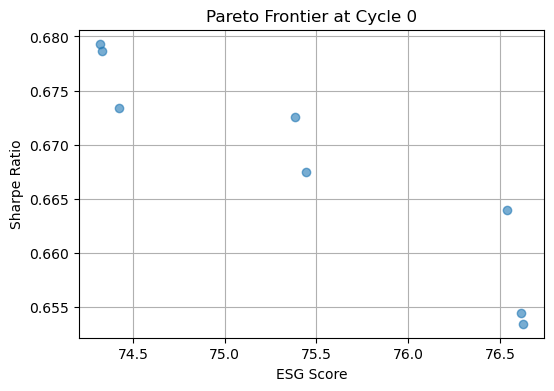

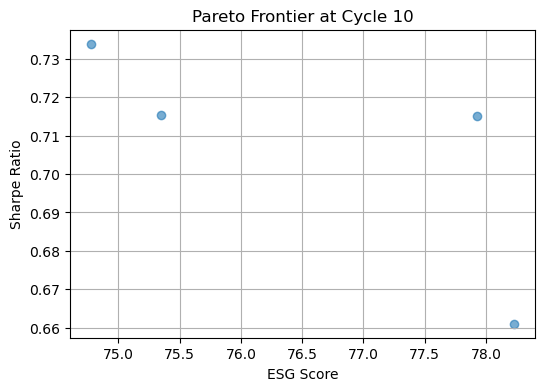

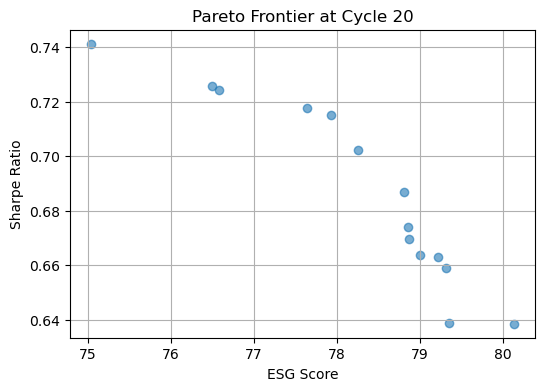

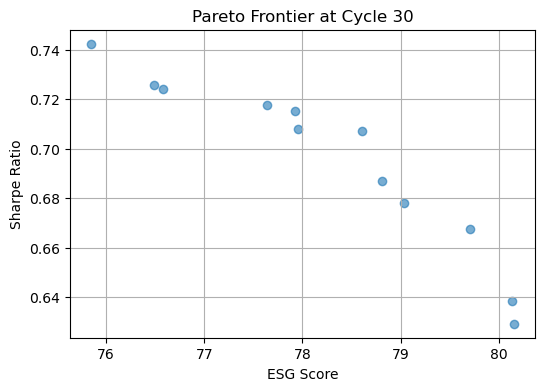

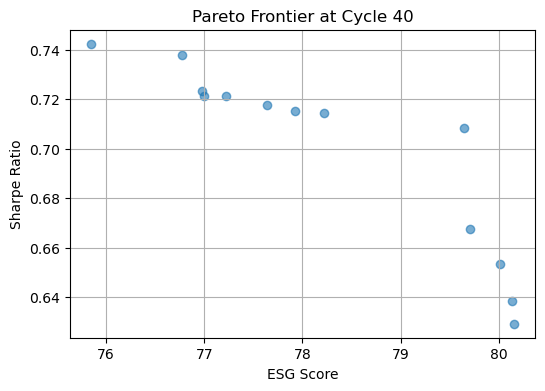

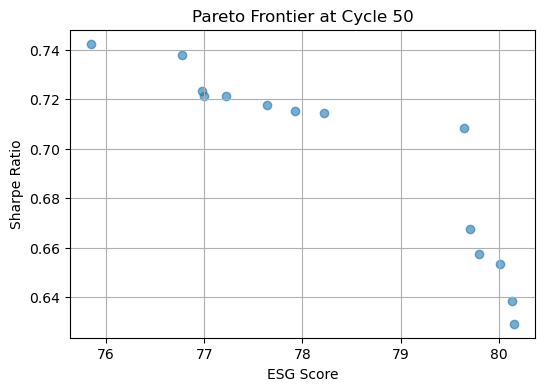

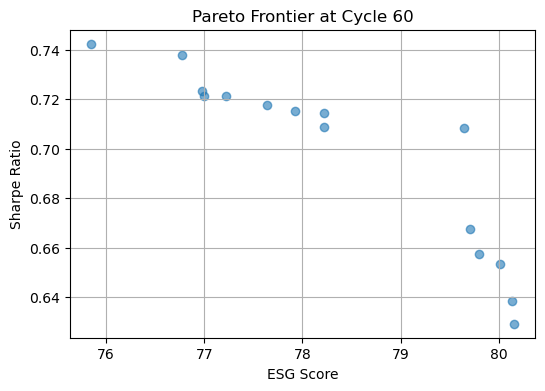

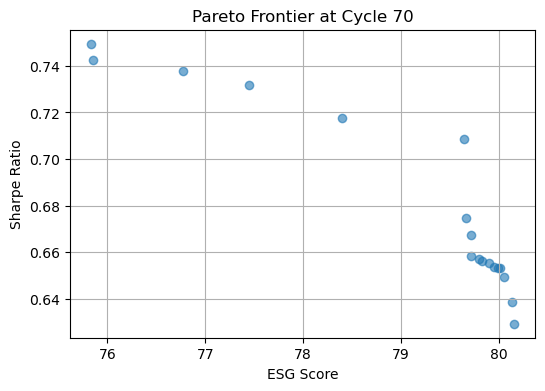

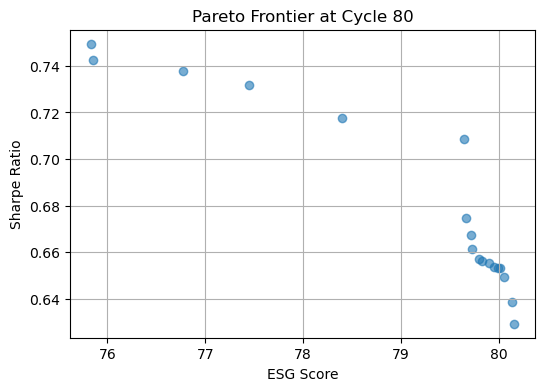

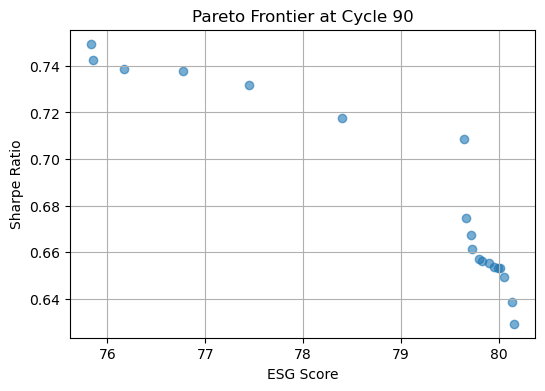

In [264]:
esg_vector = np.array(esg_scores)
pareto_test = run_abc(df_prices, esg_scores, num_bees = 20, max_cycles = 100, limit = 15, patience = 20)

In [266]:
sorted_by_sharpe = sorted(pareto_test, key=lambda x: x[0], reverse=True)
sorted_by_esg = sorted(pareto_test, key=lambda x: x[1], reverse=True)
for sharpe, esg, weights in sorted_by_esg:
    print(f"Sharpe: {sharpe:.3f}, ESG: {esg:.1f}, Weights: {np.round(weights, 2)}")

Sharpe: 0.629, ESG: 80.2, Weights: [0.37 0.37 0.19 0.06 0.01]
Sharpe: 0.639, ESG: 80.1, Weights: [0.41 0.35 0.15 0.05 0.05]
Sharpe: 0.649, ESG: 80.1, Weights: [0.35 0.35 0.26 0.02 0.01]
Sharpe: 0.653, ESG: 80.0, Weights: [0.35 0.35 0.28 0.01 0.01]
Sharpe: 0.653, ESG: 80.0, Weights: [0.35 0.35 0.28 0.02 0.01]
Sharpe: 0.654, ESG: 79.9, Weights: [0.34 0.34 0.28 0.02 0.01]
Sharpe: 0.656, ESG: 79.9, Weights: [0.34 0.34 0.3  0.01 0.01]
Sharpe: 0.656, ESG: 79.8, Weights: [0.34 0.34 0.3  0.02 0.01]
Sharpe: 0.657, ESG: 79.8, Weights: [0.33 0.33 0.31 0.01 0.01]
Sharpe: 0.661, ESG: 79.7, Weights: [0.33 0.32 0.31 0.02 0.01]
Sharpe: 0.667, ESG: 79.7, Weights: [0.34 0.31 0.31 0.03 0.01]
Sharpe: 0.674, ESG: 79.7, Weights: [0.34 0.29 0.34 0.02 0.01]
Sharpe: 0.708, ESG: 79.6, Weights: [0.39 0.22 0.32 0.05 0.01]
Sharpe: 0.718, ESG: 78.4, Weights: [0.38 0.19 0.24 0.09 0.1 ]
Sharpe: 0.732, ESG: 77.4, Weights: [0.36 0.1  0.27 0.22 0.05]
Sharpe: 0.738, ESG: 76.8, Weights: [0.35 0.02 0.32 0.25 0.06]
Sharpe: 

In [268]:
def display_archive(archive, title="Pareto Archive (Sorted)"):
    print(f"\n{title}")
    print("-" * 50)
    for i, (sharpe, esg, weights) in enumerate(archive):
        w_str = ", ".join(f"{w:.2f}" for w in weights)
        print(f"[{i+1}] Sharpe: {sharpe:.4f} | ESG: {esg:.2f} | Weights: [{w_str}]")
display_archive(sorted_by_sharpe, title="Top Portfolios by Sharpe")



Top Portfolios by Sharpe
--------------------------------------------------
[1] Sharpe: 0.7495 | ESG: 75.84 | Weights: [0.36, 0.01, 0.31, 0.09, 0.24]
[2] Sharpe: 0.7423 | ESG: 75.85 | Weights: [0.34, 0.01, 0.27, 0.24, 0.14]
[3] Sharpe: 0.7385 | ESG: 76.17 | Weights: [0.34, 0.06, 0.27, 0.16, 0.17]
[4] Sharpe: 0.7377 | ESG: 76.77 | Weights: [0.35, 0.02, 0.32, 0.25, 0.06]
[5] Sharpe: 0.7316 | ESG: 77.45 | Weights: [0.36, 0.10, 0.27, 0.22, 0.05]
[6] Sharpe: 0.7176 | ESG: 78.39 | Weights: [0.38, 0.19, 0.24, 0.09, 0.10]
[7] Sharpe: 0.7085 | ESG: 79.64 | Weights: [0.39, 0.22, 0.32, 0.05, 0.01]
[8] Sharpe: 0.6745 | ESG: 79.66 | Weights: [0.34, 0.29, 0.34, 0.02, 0.01]
[9] Sharpe: 0.6673 | ESG: 79.71 | Weights: [0.34, 0.31, 0.31, 0.03, 0.01]
[10] Sharpe: 0.6614 | ESG: 79.73 | Weights: [0.33, 0.32, 0.31, 0.02, 0.01]
[11] Sharpe: 0.6573 | ESG: 79.80 | Weights: [0.33, 0.33, 0.31, 0.01, 0.01]
[12] Sharpe: 0.6561 | ESG: 79.83 | Weights: [0.34, 0.34, 0.30, 0.02, 0.01]
[13] Sharpe: 0.6555 | ESG: 79.90